# Linear Models

Principle : Linear models make a prediction using a linear function of the input features. Each feature is assigned a weight learned by the algorithm.
There are many different linear models for classification. The difference between these models lies in how the model parameters w and b are learned from the training data, and how model complexity can be controlled. The two most common algorithms are *logistic regression* (despites its name) and *linear support vector machines*.
For both of them, the regularization parameter C can be adjusted to get better results. The higher the value, the most the algorithm is gonna give importance to every points for the dataset trying to fit as most as possible to the training set. Using low values means the algorithm is gonna try to adjust to the "majority" of the points.

### Set up

First import all necessary packages in order not to worry about them when testing new parameters/algorithms:

In [48]:
%load_ext autoreload
%autoreload
from LinearModels import display_plot_logreg, display_plot_svc
from utils import feature_selection, thomas_parser, PCA_reduction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from tabulate import tabulate
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logistic Regression

### First test

Let's try the logistic regression first with C set to the default value 1, then C=100 and eventually C=0.01.

In [23]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

logreg = LogisticRegression(max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

Training set score: 0.815
Test set score: 0.809


In [24]:
logreg100 = LogisticRegression(C=100,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg100.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg100.score(data_test, target_test)))

Training set score: 0.842
Test set score: 0.784


In [25]:
logreg001 = LogisticRegression(C=0.01,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg001.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg001.score(data_test, target_test)))

Training set score: 0.815
Test set score: 0.809


Accuracies are quite bad on the test set even with standardization. We might be underfitting and should try to tune other parameters or use bigger datasets.

### Further tests

#### Regularization parameter

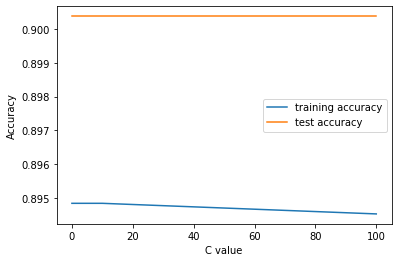

In [32]:
display_plot_logreg('../dumps/2020.02.10-12.14.csv',0.20,0.01,100)

The curves we get are nearly perfectly linear. Increase the C value does reduce a little bit the training accucary while the test one stays the same all the time (and is always better, which is quite unintuitive). We may therefore favor the smallest C value.

### Best match

In [33]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [34]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8948440683278484
{'C': 0.01, 'max_iter': 100}
0.900375939849624
{'C': 0.01, 'max_iter': 100}


In [35]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = RandomizedSearchCV(LogisticRegression(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8948440683278484
{'max_iter': 1000, 'C': 0.1}
0.900375939849624
{'max_iter': 1000, 'C': 0.1}


### Features relevance

Here below we will follow an iterative process in order to select the most relevant features of our model. The way it works is as follow : first we start a small training set, measure the accuracy and select the most relevant features using *SelectFromModel*. Then we apply the same reasoning on a slightly larger training set. Between two iterations, the set of features that is kept is the intersection between the current best features and the previous ones.

In [3]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
raw_data = gt[cols]
raw_target = gt['label']

First step, we start with a training set of 20% of the whole dataset.

In [4]:
#Computing initial accuracies without tuning
data_train, data_test, target_train, target_test = train_test_split(raw_data, raw_target, test_size = 0.85, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
data_train = pd.DataFrame(data=data_train[0:,0:],
                    index=[i for i in range(data_train.shape[0])],
                    columns=['f'+str(i) for i in range(data_train.shape[1])])
data_test = pd.DataFrame(data=data_test[0:,0:],
                    index=[i for i in range(data_test.shape[0])],
                    columns=['f'+str(i) for i in range(data_test.shape[1])])
print(data_train.shape)
logreg = LogisticRegression(C=0.01, max_iter=100)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Select best features
model = SelectFromModel(logreg, prefit=True)
train_new = model.transform(data_train)
print(train_new.shape)
mask = model.get_support()
A_set = data_train.columns[mask]

#Creating new dataset with only wanted features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[A_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.85, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
data_train = pd.DataFrame(data=data_train[0:,0:],
                    index=[i for i in range(data_train.shape[0])],
                    columns=['f'+str(i) for i in range(data_train.shape[1])])
data_test = pd.DataFrame(data=data_test[0:,0:],
                    index=[i for i in range(data_test.shape[0])],
                    columns=['f'+str(i) for i in range(data_test.shape[1])])
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

(1196, 119)
Training set score: 0.889
Test set score: 0.897
(1196, 42)
Training set score: 0.889
Test set score: 0.897


We now increase the size of the training set.

In [6]:
#Computing initial accuracies without tuning
data_train, data_test, target_train, target_test = train_test_split(raw_data, raw_target, test_size = 0.70, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
data_train = pd.DataFrame(data=data_train[0:,0:],
                    index=[i for i in range(data_train.shape[0])],
                    columns=['f'+str(i) for i in range(data_train.shape[1])])
data_test = pd.DataFrame(data=data_test[0:,0:],
                    index=[i for i in range(data_test.shape[0])],
                    columns=['f'+str(i) for i in range(data_test.shape[1])])
print(data_train.shape)
logreg = LogisticRegression(C=0.01, max_iter=100)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Select best features
model = SelectFromModel(logreg, prefit=True)
train_new = model.transform(data_train)
print(train_new.shape)
mask = model.get_support()
B_set = data_train.columns[mask]

#Creating new dataset with only wanted features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[B_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.70, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
data_train = pd.DataFrame(data=data_train[0:,0:],
                    index=[i for i in range(data_train.shape[0])],
                    columns=['f'+str(i) for i in range(data_train.shape[1])])
data_test = pd.DataFrame(data=data_test[0:,0:],
                    index=[i for i in range(data_test.shape[0])],
                    columns=['f'+str(i) for i in range(data_test.shape[1])])
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Creating new dataset with A's best features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[A_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.70, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
data_train = pd.DataFrame(data=data_train[0:,0:],
                    index=[i for i in range(data_train.shape[0])],
                    columns=['f'+str(i) for i in range(data_train.shape[1])])
data_test = pd.DataFrame(data=data_test[0:,0:],
                    index=[i for i in range(data_test.shape[0])],
                    columns=['f'+str(i) for i in range(data_test.shape[1])])
print(data_train.shape)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Intersection of two subsets with the best features
C_set = [value for value in B_set if value in A_set]

(2393, 119)
Training set score: 0.901
Test set score: 0.894
(2393, 43)
Training set score: 0.901
Test set score: 0.894
(2393, 42)
Training set score: 0.901
Test set score: 0.894


We now carry on repeating the same process : increasing the training set, finding the best features and the intersection with the previous set until convergence.

0.15
(1196, 119)
(1196, 42)
0.3
(2393, 119)
(2393, 43)
30
0.44999999999999996
(3589, 119)
(3589, 39)
21
0.6
(4786, 119)
(4786, 38)
16
0.75
(5982, 119)
(5982, 38)
13
0.9
(7179, 119)
(7179, 34)
10


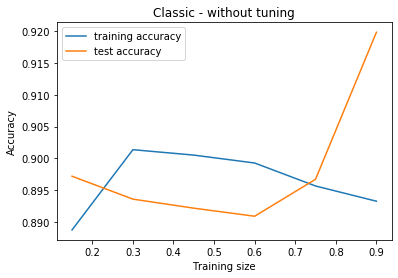

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


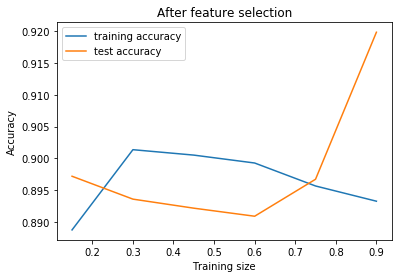

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


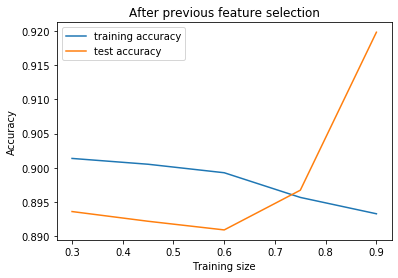

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


In [13]:
feature_selection('../dumps/2020.02.10-12.14.csv', 0.15, "log")

All results are the same, which means that the model can definitely be reduced to a few number of features.

Let's, once more, try the feature extraction on a dataset of 14K samples and see how the performances are impacted.

0.15
(2205, 119)
(2205, 8)
0.3
(4410, 119)
(4410, 9)
8
0.44999999999999996
(6616, 119)
(6616, 9)
8
0.6
(8821, 119)
(8821, 9)
8
0.75
(11027, 119)
(11027, 9)
8
0.9
(13232, 119)
(13232, 9)
8


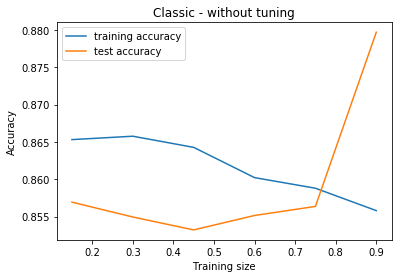

Training max value : 0.8657596371882086
Test max value : 0.8796736913664174


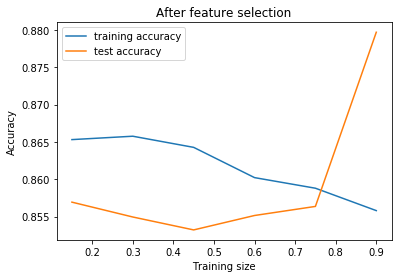

Training max value : 0.8657596371882086
Test max value : 0.8796736913664174


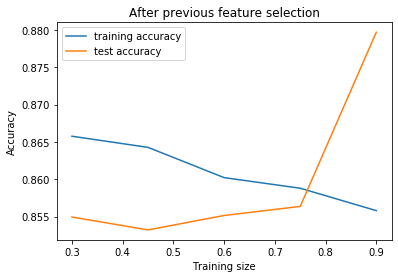

Training max value : 0.8657596371882086
Test max value : 0.8796736913664174


In [14]:
feature_selection('../dumps/2020.03.11-17.39.csv',0.15,"log")

We can observe that after the first iteration and until the end, the 8 same features are always selected for the last case. Once again, since all values are the same, we can conclude than our model doesn't need more than 8 features in order to be efficient.

## Linear SVC

### First test

Same procedure as done before with logistic regression where a first test is made with C value set to 1, 100 and 0.01.

In [52]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [53]:
linsvc = LinearSVC(max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc.score(data_test, target_test)))

Training set score: 0.829
Test set score: 0.794


In [54]:
linsvc100 = LinearSVC(C=100,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc100.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc100.score(data_test, target_test)))

Training set score: 0.840
Test set score: 0.774


In [55]:
linsvc001 = LinearSVC(C=0.01,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc001.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc001.score(data_test, target_test)))

Training set score: 0.815
Test set score: 0.809


Results are quite similar to the ones we got with Logistic Regression, maybe even worse regarding the test set.

### Further tests

### Regularization parameter

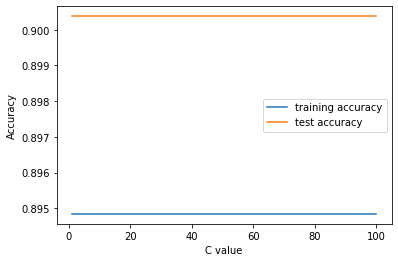

In [56]:
display_plot_svc('../dumps/2020.02.10-12.14.csv',0.20,1,100)

Same conclusion as with the previous Linear Regression.

### Best match

In [57]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [58]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = GridSearchCV(LinearSVC(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8948440683278484
{'C': 0.01, 'max_iter': 100}
0.900375939849624
{'C': 0.01, 'max_iter': 100}


In [59]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = RandomizedSearchCV(LinearSVC(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8948440683278484
{'max_iter': 10000, 'C': 100}
0.900375939849624
{'max_iter': 10000, 'C': 100}


### Features relevance

See LinearRegression in order to understand which processus we follow to generate the values.

0.15
(1196, 119)
(1196, 47)
0.3
(2393, 119)
(2393, 51)
34
0.44999999999999996
(3589, 119)
(3589, 51)
23
0.6
(4786, 119)
(4786, 47)
18
0.75
(5982, 119)
(5982, 53)
14
0.9
(7179, 119)
(7179, 41)
10


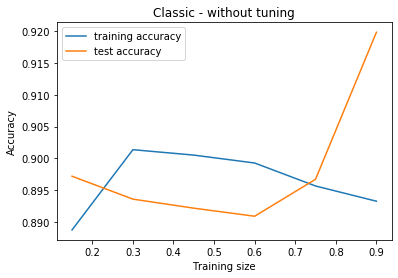

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


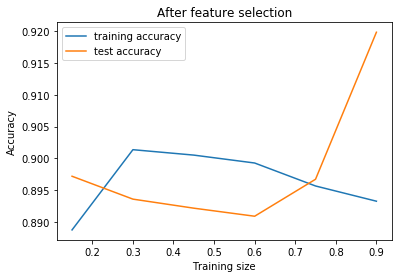

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


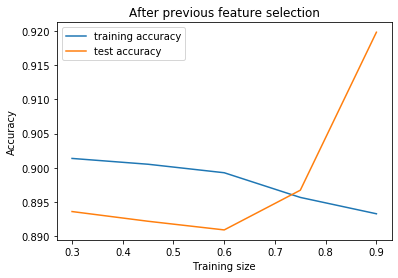

Training max value : 0.9013790221479314
Test max value : 0.9197994987468672


In [27]:
feature_selection('../dumps/2020.02.10-12.14.csv', 0.15, "svc")

The results here are different that the other linear algorithm. We have multiple drops at different intervals and the best value we get is when considering the intersection of all the best features.

Let's also test with the bigger dataset of 14k samples.

0.15
(2205, 119)
(2205, 8)
0.3
(4410, 119)
(4410, 9)
8
0.44999999999999996
(6616, 119)
(6616, 9)
8
0.6
(8821, 119)
(8821, 9)
8
0.75
(11027, 119)
(11027, 9)
8
0.9
(13232, 119)
(13232, 7)
6


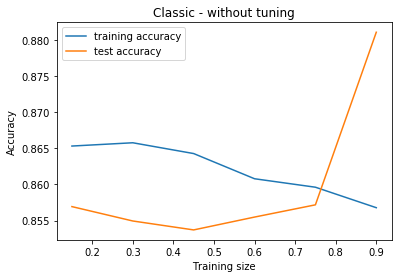

Training max value : 0.8657596371882086
Test max value : 0.8810333106730116


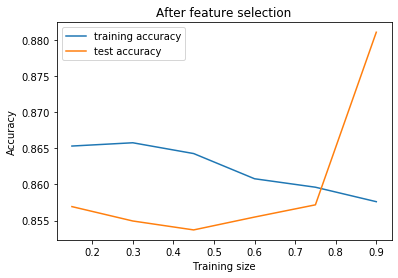

Training max value : 0.8657596371882086
Test max value : 0.8810333106730116


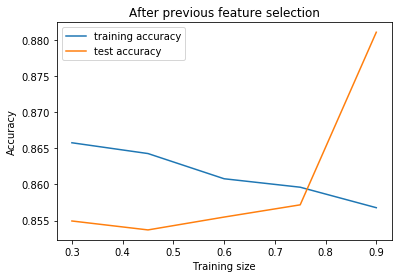

Training max value : 0.8657596371882086
Test max value : 0.8810333106730116


In [28]:
feature_selection('../dumps/2020.03.11-17.39.csv',0.15,"svc")

The conclusions are the same as the ones we infered from the previous regression except that here we reduced the number of features to 10 instead of 8.

### Test on Thomas datasets

In [31]:
gt = pd.read_csv("../dumps/2019-08.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

tree = LogisticRegression(C=1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.785
Accuracy on test set: 0.779


In [32]:
gt = pd.read_csv("../dumps/2019-09.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

tree = LogisticRegression(C=1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.800
Accuracy on test set: 0.804


In [36]:
gt = pd.read_csv("../dumps/2019-08.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

tree = LinearSVC(C=0.1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.783
Accuracy on test set: 0.776


In [35]:
gt = pd.read_csv("../dumps/2019-09.Merged_thomas.csv")
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
scaler = Normalizer()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

tree = LinearSVC(C=0.1, max_iter=10000,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.795
Accuracy on test set: 0.800


### PCA

Let's see if we can make some clustering with the features in order to save time while slightly decreasing the accuracies for the two linear models.

In [45]:
PCA_reduction('../dumps/2020.03.11-17.39.csv','log')

  Variance    Training acc    Test acc    Components    Time (s)
----------  --------------  ----------  ------------  ----------
      1           0.982316    0.977219           119    0.209617
      0.99        0.981721    0.977219            98    0.207728
      0.95        0.980956    0.974498            77    0.187958
      0.9         0.978065    0.973138            60    0.178824
      0.85        0.976024    0.970078            47    0.171602


In [49]:
PCA_reduction('../dumps/2020.03.11-17.39.csv','svc')

  Variance    Training acc    Test acc    Components    Time (s)
----------  --------------  ----------  ------------  ----------
      1           0.982656    0.977899           119    1.24748
      0.99        0.981211    0.975859            98    0.955132
      0.95        0.981296    0.973478            77    1.25268
      0.9         0.977895    0.973478            60    1.28197
      0.85        0.976195    0.972458            47    2.32675


Interesting to notice that in the case of the LogReg, accuracies are reduced but we save time while for the LinearSVC gathering features decreases the performances and is more time consuming.